## 案例 3: 生活中的資料科學 - 2020 第 15 任總統（副總統）選舉資料庫數據分析
- 中選會的選舉資料庫網站提供歷屆公職選舉資料集，例如正副總統選舉、立法委員選舉、各縣市長選舉，甚或多年前的國大代表選舉等資料集。
- 這些資料集都公開提供全民下載。但是，下載資料以後，你必須針對本身的需求，再去整理分析這些資料。
- 此案例以 2020 年第 15 任總統（副總統）選舉資料庫為例。
- 資料來源: https://db.cec.gov.tw/histMain.jsp?voteSel=20200101A1

### 第一階段清理

In [13]:
from urllib.parse import quote
import pandas as pd
from string import ascii_uppercase
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# 檔案名稱
file_name = "總統-A05-4-候選人得票數一覽表-各投開票所(臺北市).xls" 

# 中文檔案名稱要轉譯為 URL 的代碼
file_name_url = quote(file_name)

# 檔案路徑 (含檔案名稱)
file_path = "https://taiwan-election-data.s3-ap-northeast-1.amazonaws.com/presidential_2020/{}".format(file_name_url)

# 讀取檔案
xls_df = pd.read_excel(file_path)
#xls_df = pd.read_excel(file_path, skiprows=[0, 1, 3, 4])

# 檢視檔案基本架構
xls_df.head()

,第15任總統副總統選舉候選人在臺北市各投開票所得票數一覽表,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,鄉(鎮、市、區)別,村里別,投票所別,各組候選人得票情形,NaN,NaN,有效票數A\nA=1+2+...+N,無效票數B,投票數C\nC=A+B,已領未投票數\nD\nD=E-C,發出票數E\nE=C+D,用餘票數F,選舉人數G\nG=E+F,投票率H\nH=C÷G
1,NaN,NaN,NaN,(1)\n宋楚瑜\n余湘,(2)\n韓國瑜\n張善政,(3)\n蔡英文\n賴清德,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,總 計,NaN,NaN,"70,769","685,830","875,854","1,632,453","21,381","1,653,834",143,"1,653,977","513,287","2,167,264",76.3098


In [15]:
# 重新讀入檔案，但跳過第 0, 2, 3, 4 列
xls_df = pd.read_excel(file_path, skiprows=[0, 2, 3, 4])
xls_df.head()

,鄉(鎮、市、區)別,村里別,投票所別,各組候選人得票情形,Unnamed: 4,Unnamed: 5,有效票數A\nA=1+2+...+N,無效票數B,投票數C\nC=A+B,已領未投票數\nD\nD=E-C,發出票數E\nE=C+D,用餘票數F,選舉人數G\nG=E+F,投票率H\nH=C÷G
0,總 計,NaN,NaN,"70,769","685,830","875,854","1,632,453","21,381","1,653,834",143,"1,653,977","513,287","2,167,264",76.3098
1,松山區,NaN,NaN,"5,436","55,918","64,207","125,561","1,762","127,323",2,"127,325","37,329","164,654",77.3276
2,NaN,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,NaN,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,NaN,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811


In [16]:
# 此時的欄位名稱很混亂，需要調整
xls_df.columns

Index(['鄉(鎮、市、區)別', '村里別', '投票所別', '各組候選人得票情形', 'Unnamed: 4', 'Unnamed: 5',
       '有效票數A\nA=1+2+...+N', '無效票數B', '投票數C\nC=A+B', '已領未投票數\nD\nD=E-C',
       '發出票數E\nE=C+D', '用餘票數F', '選舉人數G\nG=E+F', '投票率H\nH=C÷G'],
      dtype='object')

In [17]:
# 去除欄位名稱多餘的字
column_names = xls_df.columns
column_names = column_names.str.strip('123ABCDEFGH...N+-*÷=\n')

In [18]:
column_names

Index(['鄉(鎮、市、區)別', '村里別', '投票所別', '各組候選人得票情形', 'Unnamed: 4', 'Unnamed: 5',
       '有效票數', '無效票數', '投票數', '已領未投票數', '發出票數', '用餘票數', '選舉人數', '投票率'],
      dtype='object')

- 但發現有 3 個欄位 **<u>各組候選人得票情形', 'Unnamed: 4', 'Unnamed: 5'</u>** 依該要填入 3 組候選人的姓名，目前尚未修正

In [19]:
# 寫入 3 位候選人姓名
column_names.values[[3,4,5]] = ['宋楚瑜/余湘', '韓國瑜/張善政', '蔡英文/賴清德']
column_names

Index(['鄉(鎮、市、區)別', '村里別', '投票所別', '宋楚瑜/余湘', '韓國瑜/張善政', '蔡英文/賴清德', '有效票數',
       '無效票數', '投票數', '已領未投票數', '發出票數', '用餘票數', '選舉人數', '投票率'],
      dtype='object')

In [20]:
# 再將調整後的欄位名稱寫回 xls_df
xls_df.columns = column_names.values

# 檢查 xls_df
xls_df.head(10)

,鄉(鎮、市、區)別,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
0,總 計,NaN,NaN,"70,769","685,830","875,854","1,632,453","21,381","1,653,834",143,"1,653,977","513,287","2,167,264",76.3098
1,松山區,NaN,NaN,"5,436","55,918","64,207","125,561","1,762","127,323",2,"127,325","37,329","164,654",77.3276
2,NaN,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,NaN,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,NaN,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811
5,NaN,莊敬里,576.0,43,389,462,894,14,908,0,908,271,"1,179",77.0144
6,NaN,東榮里,577.0,38,431,545,"1,014",18,"1,032",0,"1,032",272,"1,304",79.1411
7,NaN,東榮里,578.0,35,501,509,"1,045",12,"1,057",0,"1,057",304,"1,361",77.6635
8,NaN,東榮里,579.0,42,406,532,980,14,994,0,994,272,"1,266",78.5150
9,NaN,東榮里,580.0,28,397,544,969,11,980,0,980,250,"1,230",79.6748


### 第二階段清理

- 第一欄的鄉(鎮、市、區)別行政區有許多 NaN，需要填入內容。
- 使用 Series 的 *.fillna()* 方法指定 *method='ffill'* 讓行政區遺漏值以前一個行政區的名稱填補。

In [21]:
# 取出 '鄉(鎮、市、區)別' 的欄位
refilled_district = xls_df['鄉(鎮、市、區)別']

In [22]:
# 檢視 '鄉(鎮、市、區)別' 資料筆數
print(refilled_district.isnull().sum()) # 沒有標註'鄉(鎮、市、區)別'的區域
print(refilled_district.notnull().sum()) # 有'鄉(鎮、市、區)別'的區域
print(refilled_district.shape[0]) # 所有資料筆數

1728
13
1741


In [23]:
# 填入空格: 使用 Series 的 .fillna() 方法指定 method='ffill'，讓行政區遺漏值以前一個行政區的名稱填補
refilled_district = refilled_district.fillna(method='ffill')

In [24]:
# 再檢視是否填入行政區的遺漏值
refilled_district.tail()

1736    　北投區
1737    　北投區
1738    　北投區
1739    　北投區
1740    　北投區
Name: 鄉(鎮、市、區)別, dtype: object

In [25]:
# 將 refilled_district 替換 xls_df 原本的 'district' 欄位
xls_df = xls_df.drop('鄉(鎮、市、區)別', axis=1) # 刪除原本 '鄉(鎮、市、區)別' 欄位
xls_df.insert(0, '區域', refilled_district) # 插入修改後的欄位，並命名為 '區域'

In [26]:
xls_df.head()

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
0,總 計,NaN,NaN,"70,769","685,830","875,854","1,632,453","21,381","1,653,834",143,"1,653,977","513,287","2,167,264",76.3098
1,松山區,NaN,NaN,"5,436","55,918","64,207","125,561","1,762","127,323",2,"127,325","37,329","164,654",77.3276
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811


- 目前的資料看起來還是有部分 NaN

In [27]:
xls_df[xls_df.isnull().any(axis=1)]

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
0,總 計,NaN,NaN,"70,769","685,830","875,854","1,632,453","21,381","1,653,834",143,"1,653,977","513,287","2,167,264",76.3098
1,松山區,NaN,NaN,"5,436","55,918","64,207","125,561","1,762","127,323",2,"127,325","37,329","164,654",77.3276
134,信義區,NaN,NaN,"5,878","62,353","70,285","138,516","1,764","140,280",35,"140,315","44,189","184,504",76.0309
301,大安區,NaN,NaN,"7,534","85,490","88,977","182,001","2,501","184,502",22,"184,524","62,035","246,559",74.8308
496,中山區,NaN,NaN,"6,367","56,491","79,022","141,880","1,922","143,802",2,"143,804","46,386","190,190",75.6097
640,中正區,NaN,NaN,"4,188","41,461","48,183","93,832","1,292","95,124",2,"95,126","29,834","124,960",76.1236
756,大同區,NaN,NaN,"3,463","24,673","50,006","78,142",971,"79,113",5,"79,118","24,970","104,088",76.0059
845,萬華區,NaN,NaN,"5,008","46,700","66,866","118,574","1,536","120,110",5,"120,115","39,188","159,303",75.3972
983,文山區,NaN,NaN,"7,502","82,305","78,129","167,936","2,339","170,275",3,"170,278","50,836","221,114",77.0078
1155,南港區,NaN,NaN,"3,409","30,968","40,969","75,346","1,010","76,356",0,"76,356","22,479","98,835",77.2560


- 這部分的資料是總計，或是各行政區的小計，在分析時我們只需要原始資料，這部分的綜整資料容易構成日後分析資料時的困擾，應該刪除。

In [28]:
# 刪除 NaN 列，只要有 NaN 則整列刪除
xls_df = xls_df.dropna(how='any')

In [29]:
xls_df.head(10)

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811
5,松山區,莊敬里,576.0,43,389,462,894,14,908,0,908,271,"1,179",77.0144
6,松山區,東榮里,577.0,38,431,545,"1,014",18,"1,032",0,"1,032",272,"1,304",79.1411
7,松山區,東榮里,578.0,35,501,509,"1,045",12,"1,057",0,"1,057",304,"1,361",77.6635
8,松山區,東榮里,579.0,42,406,532,980,14,994,0,994,272,"1,266",78.5150
9,松山區,東榮里,580.0,28,397,544,969,11,980,0,980,250,"1,230",79.6748
10,松山區,東榮里,581.0,31,438,530,999,18,"1,017",0,"1,017",311,"1,328",76.5813
11,松山區,三民里,582.0,46,387,531,964,5,969,0,969,246,"1,215",79.7531


- NaN 的資料列已經完全清除
- 在接下要進行資料分析前，先檢查各欄位的資料型態

In [30]:
xls_df.dtypes

區域          object
村里別         object
投票所別       float64
宋楚瑜/余湘      object
韓國瑜/張善政     object
蔡英文/賴清德     object
有效票數        object
無效票數        object
投票數         object
已領未投票數       int64
發出票數        object
用餘票數        object
選舉人數        object
投票率        float64
dtype: object

### 請進行資料型態的轉換，完成下列 5 個題目

#### 3-1: 請計算各組候選人在各行政區域的得票總數，並繪製長條圖

In [31]:
df=xls_df

In [32]:
df

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811
5,松山區,莊敬里,576.0,43,389,462,894,14,908,0,908,271,"1,179",77.0144
6,松山區,東榮里,577.0,38,431,545,"1,014",18,"1,032",0,"1,032",272,"1,304",79.1411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,北投區,泉源里,156.0,48,372,721,"1,141",8,"1,149",0,"1,149",448,"1,597",71.9474
1737,北投區,湖山里,157.0,25,219,344,588,5,593,0,593,212,805,73.6646
1738,北投區,湖山里,158.0,23,191,282,496,7,503,0,503,188,691,72.7931
1739,北投區,大屯里,159.0,34,195,542,771,10,781,0,781,300,"1,081",72.2479


In [33]:
df['蔡英文/賴清德'][1655]=df['蔡英文/賴清德'][1655].replace(',','')
df['蔡英文/賴清德']

2       429
3       438
4       389
5       462
6       545
       ... 
1736    721
1737    344
1738    282
1739    542
1740    350
Name: 蔡英文/賴清德, Length: 1728, dtype: object

In [34]:
df['宋楚瑜/余湘']=df['宋楚瑜/余湘'].astype(int)
df['韓國瑜/張善政']=df['韓國瑜/張善政'].astype(int)

In [35]:
df['蔡英文/賴清德']=df['蔡英文/賴清德'].astype(int)

In [36]:
gap = df.groupby(by='區域')[['宋楚瑜/余湘','韓國瑜/張善政','蔡英文/賴清德']].sum()
gap

,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德
區域,,,
中山區,6367,56491,79022
中正區,4188,41461,48183
信義區,5878,62353,70285
內湖區,8356,74437,94269
北投區,6443,59851,90060
南港區,3409,30968,40969
士林區,7185,65183,104881
大同區,3463,24673,50006
大安區,7534,85490,88977


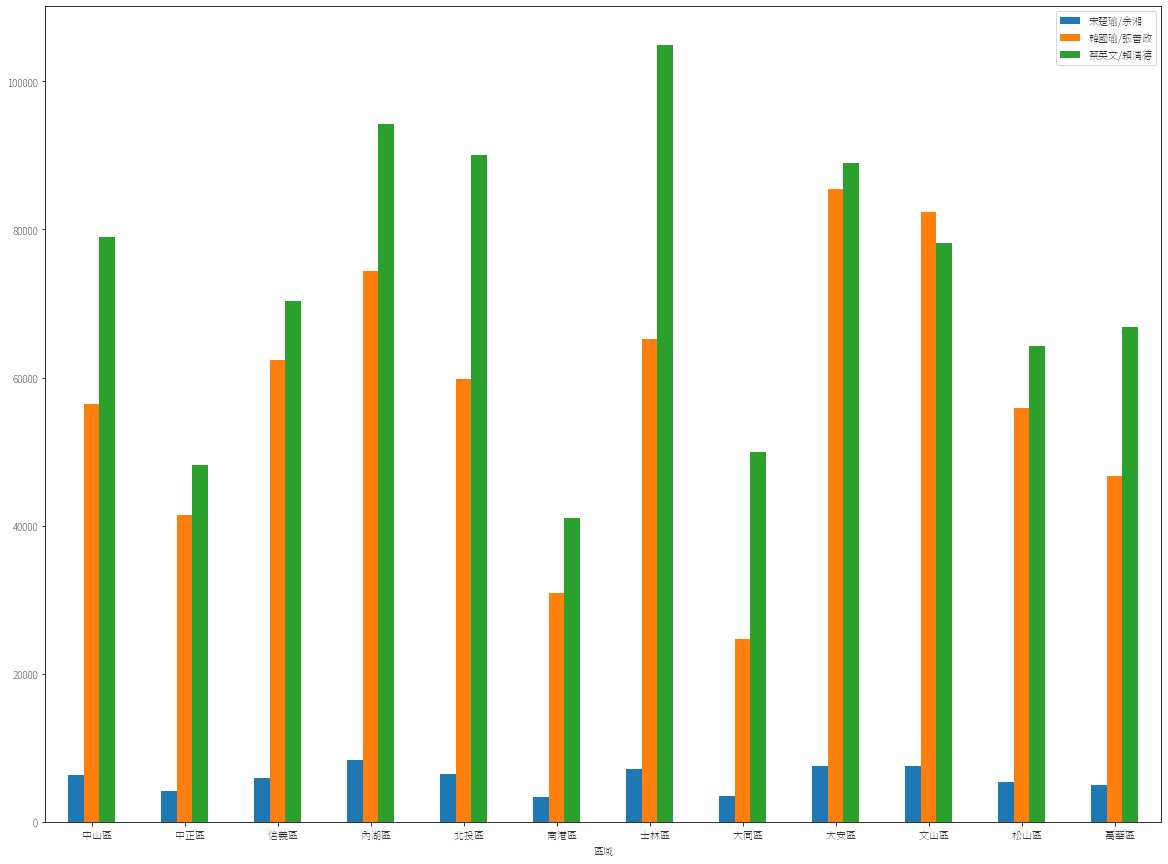

In [38]:
plt.rcParams["figure.figsize"] = (20,15)
gap.plot(kind = 'bar', rot = 0)
plt.show()

In [ ]:
#中文字體設定 https://pyecontech.com/2020/03/27/python%E6%95%99%E5%AD%B8-%E5%A6%82%E4%BD%95%E8%A7%A3%E6%B1%BAmatplotlib%E4%B8%AD%E6%96%87%E4%BA%82%E7%A2%BC%E5%95%8F%E9%A1%8C/

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']

In [8]:
#找出所有字體
import matplotlib.font_manager
 
a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
 
for i in a:
    print(i)

Agency FB
Agency FB
Algerian
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial Rounded MT Bold
Arial Unicode MS
Bahnschrift
Baskerville Old Face
Bauhaus 93
Bell MT
Bell MT
Bell MT
Berlin Sans FB
Berlin Sans FB
Berlin Sans FB Demi
Bernard MT Condensed
Blackadder ITC
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Bodoni MT
Book Antiqua
Book Antiqua
Book Antiqua
Book Antiqua
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookshelf Symbol 7
Bradley Hand ITC
Britannic Bold
Broadway
Brush Script MT
Calibri
Calibri
Calibri
Calibri
Calibri
Calibri
Californian FB
Californian FB
Californian FB
Calisto MT
Calisto MT
Calisto MT
Calisto MT
Cambria
Cambria
Cambria
Cambria
Candara
Candara
Candara
Candara
Candara
Candara
Castellar
Centaur
Century
Century Gothic
Century Gothic
Century Gothic
Century Gothic
Century Schoolbook
Century Schoolbook
Century Schoolbook
Century Schoolbook
Chiller
Colonna MT
Comic Sans MS
Co

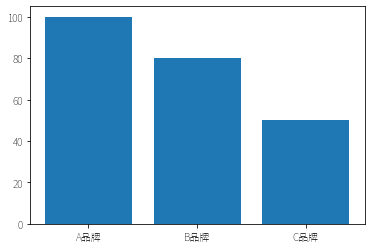

In [12]:
import matplotlib.pyplot as plt
 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
 
sales = [100,80,50]
x_labels = ['A品牌','B品牌','C品牌']
 
plt.bar(x_labels,sales)
plt.show()

#### 3-2: 請計算各組候選人在各行政區域的得票率，並繪製折線圖

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 資料清理函式
def cleanup(xls_df2):
#----- 第一階段清理 -----#
    # 去除欄位名稱多餘的字
    column_names = xls_df2.columns
    column_names = column_names.str.strip('123ABCDEFGH...N+-*÷=\n')
    
    # 寫入 3 組候選人姓名為欄位名稱
    column_names.values[[3,4,5]] = ['宋楚瑜/余湘', '韓國瑜/張善政', '蔡英文/賴清德']

    # 再將調整後的欄位名稱寫回 xls_df2
    xls_df2.columns = column_names.values
    
#----- 第二階段清理 -----#
    # 拉出 '鄉(鎮、市、區)別' 的欄位
    refilled_district = xls_df2['鄉(鎮、市、區)別']

    # 填入空格: 使用 Series 的 .fillna() 方法指定 method='ffill'，讓行政區遺漏值以前一個行政區的名稱填補
    refilled_district = refilled_district.fillna(method='ffill')

    # 將 refilled_district 替換 xls_df 原本的 'district' 欄位
    xls_df2 = xls_df2.drop('鄉(鎮、市、區)別', axis=1)
    xls_df2.insert(0, '區域', refilled_district)

    # 刪除 NaN 列，只要有 NaN 則整列刪除
    xls_df2 = xls_df2.dropna(how='any')
    
    # 重新調整 index 
    #xls_df2.index = range(0, 1728, 1)
    
    return xls_df2

In [302]:
#----- 讀取外部檔案 -----#
# 檔案名稱
from urllib.parse import quote
file_name = "總統-A05-4-候選人得票數一覽表-各投開票所(臺北市).xls" 

# 中文檔案名稱要轉譯為 URL 的代碼
file_name_url = quote(file_name)

# 檔案路徑 (含檔案名稱)
file_path = "https://taiwan-election-data.s3-ap-northeast-1.amazonaws.com/presidential_2020/{}".format(file_name_url)

# 讀取檔案，thousands 參數將有逗號','的字串解析為數字，跳過第 0, 2, 3, 4 列
xls_df2 = pd.read_excel(file_path, thousands=',', skiprows=[0, 2, 3, 4])

# 呼叫 cleanup() 函式清理資料
xls_df2 = cleanup(xls_df2)

In [303]:
print('2020 第 15 任總統（副總統）選舉台北市得票情況...')
print('蔡英文/賴清德: {} 票'.format(xls_df2['蔡英文/賴清德'].sum()))
print('韓國瑜/張善政: {} 票'.format(xls_df2['韓國瑜/張善政'].sum()))
print('宋楚瑜/余湘: {} 票'.format(xls_df2['宋楚瑜/余湘'].sum()))

2020 第 15 任總統（副總統）選舉台北市得票情況...
蔡英文/賴清德: 875854 票
韓國瑜/張善政: 685830 票
宋楚瑜/余湘: 70769 票


In [304]:
#xls_df2['宋楚瑜/余湘'] / xls_df2['有效票數']
x1 = xls_df2.groupby('區域')[['宋楚瑜/余湘', '韓國瑜/張善政', '蔡英文/賴清德']].sum()
x2 = xls_df2.groupby('區域')['有效票數'].sum()

x1.apply(lambda x: x/x2 ) #個組候選人得票率

,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德
區域,,,
中山區,0.044876,0.398160,0.556964
中正區,0.044633,0.441864,0.513503
信義區,0.042436,0.450150,0.507414
內湖區,0.047193,0.420401,0.532407
北投區,0.041208,0.382792,0.576001
南港區,0.045245,0.411011,0.543745
士林區,0.040536,0.367748,0.591716
大同區,0.044317,0.315746,0.639938
大安區,0.041395,0.469723,0.488882


Text(0, 0.5, '得票率')

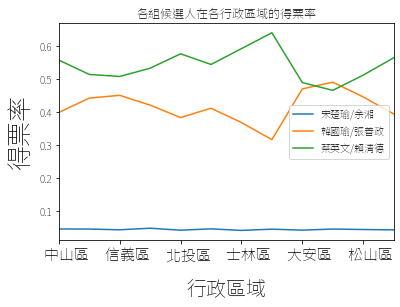

In [312]:
x1.div(x2, axis=0).plot(kind='line')
plt.xticks(fontsize=15)
plt.title("各組候選人在各行政區域的得票率")
plt.xlabel("行政區域", fontsize=20, labelpad = 15)
plt.ylabel("得票率", fontsize=25, labelpad = 5)

In [39]:
df

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811
5,松山區,莊敬里,576.0,43,389,462,894,14,908,0,908,271,"1,179",77.0144
6,松山區,東榮里,577.0,38,431,545,"1,014",18,"1,032",0,"1,032",272,"1,304",79.1411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,北投區,泉源里,156.0,48,372,721,"1,141",8,"1,149",0,"1,149",448,"1,597",71.9474
1737,北投區,湖山里,157.0,25,219,344,588,5,593,0,593,212,805,73.6646
1738,北投區,湖山里,158.0,23,191,282,496,7,503,0,503,188,691,72.7931
1739,北投區,大屯里,159.0,34,195,542,771,10,781,0,781,300,"1,081",72.2479


In [ ]:
for i in range(len(df)):
    df['投票數'].iloc[i]=df['投票數'].iloc[i].replace(',','')
df['投票數']

In [318]:
df['投票數']=df['投票數'].astype(int)

In [319]:
gap1 = df.groupby(by='區域')[['宋楚瑜/余湘']].sum()
gap2 = df.groupby(by='區域')[['韓國瑜/張善政']].sum()
gap3 = df.groupby(by='區域')[['蔡英文/賴清德']].sum()
areaSum = df.groupby(by='區域')[['投票數']].sum()
gap01 = gap1['宋楚瑜/余湘']/areaSum['投票數']
gap02 = gap2['韓國瑜/張善政']/areaSum['投票數']
gap03 = gap3['蔡英文/賴清德']/areaSum['投票數']

In [320]:
for i in range(12):
    W[i]=W[i].replace('\u3000','')
W

array(['松山區', '信義區', '大安區', '中山區', '中正區', '大同區', '萬華區', '文山區', '南港區',
       '內湖區', '士林區', '北投區'], dtype=object)

In [324]:
x=[]
y=[]
z=[]
for i in range(len(gap01)):
    x.append(gap01.iloc[i])
for i in range(len(gap02)):
    y.append(gap02.iloc[i])
for i in range(len(gap03)):
    z.append(gap03.iloc[i])

In [ ]:
x1={'區域':W,'宋楚瑜/余湘':x}
y1={'區域':W,'韓國瑜/張善政':y}
z1={'區域':W,'蔡英文/賴清德':z}

In [327]:
df02 = pd.DataFrame(x1,columns=['區域', '宋楚瑜/余湘'])
df03 = pd.DataFrame(y1,columns=['區域', '韓國瑜/張善政'])
df04 = pd.DataFrame(z1,columns=['區域', '蔡英文/賴清德'])

In [328]:
df2=pd.merge(df02,df03)
df2=pd.merge(df2,df04)

In [331]:
G=[]
for i in range(12):
    G.append(W[i])
G

['松山區',
 '信義區',
 '大安區',
 '中山區',
 '中正區',
 '大同區',
 '萬華區',
 '文山區',
 '南港區',
 '內湖區',
 '士林區',
 '北投區']

In [334]:
Test=df2
df2

,區域,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德
0,松山區,0.044276,0.392839,0.549519
1,信義區,0.044027,0.435863,0.506528
2,大安區,0.041902,0.444490,0.501034
3,中山區,0.046575,0.414897,0.525436
4,中正區,0.040709,0.378160,0.569031
5,大同區,0.044646,0.405574,0.536552
6,萬華區,0.040079,0.363604,0.585048
7,文山區,0.043773,0.311870,0.632083
8,南港區,0.040834,0.463355,0.482255
9,內湖區,0.044058,0.483365,0.458840


In [335]:
#df2.index = Series(G)
#'松山區','信義區','大安區','中山區','中正區','大同區','萬華區','文山區','南港區','內湖區','士林區','北投區'
Test.index=G
Test=Test.drop(['區域'], axis=1)
Test

,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德
松山區,0.044276,0.392839,0.549519
信義區,0.044027,0.435863,0.506528
大安區,0.041902,0.444490,0.501034
中山區,0.046575,0.414897,0.525436
中正區,0.040709,0.378160,0.569031
大同區,0.044646,0.405574,0.536552
萬華區,0.040079,0.363604,0.585048
文山區,0.043773,0.311870,0.632083
南港區,0.040834,0.463355,0.482255
內湖區,0.044058,0.483365,0.458840


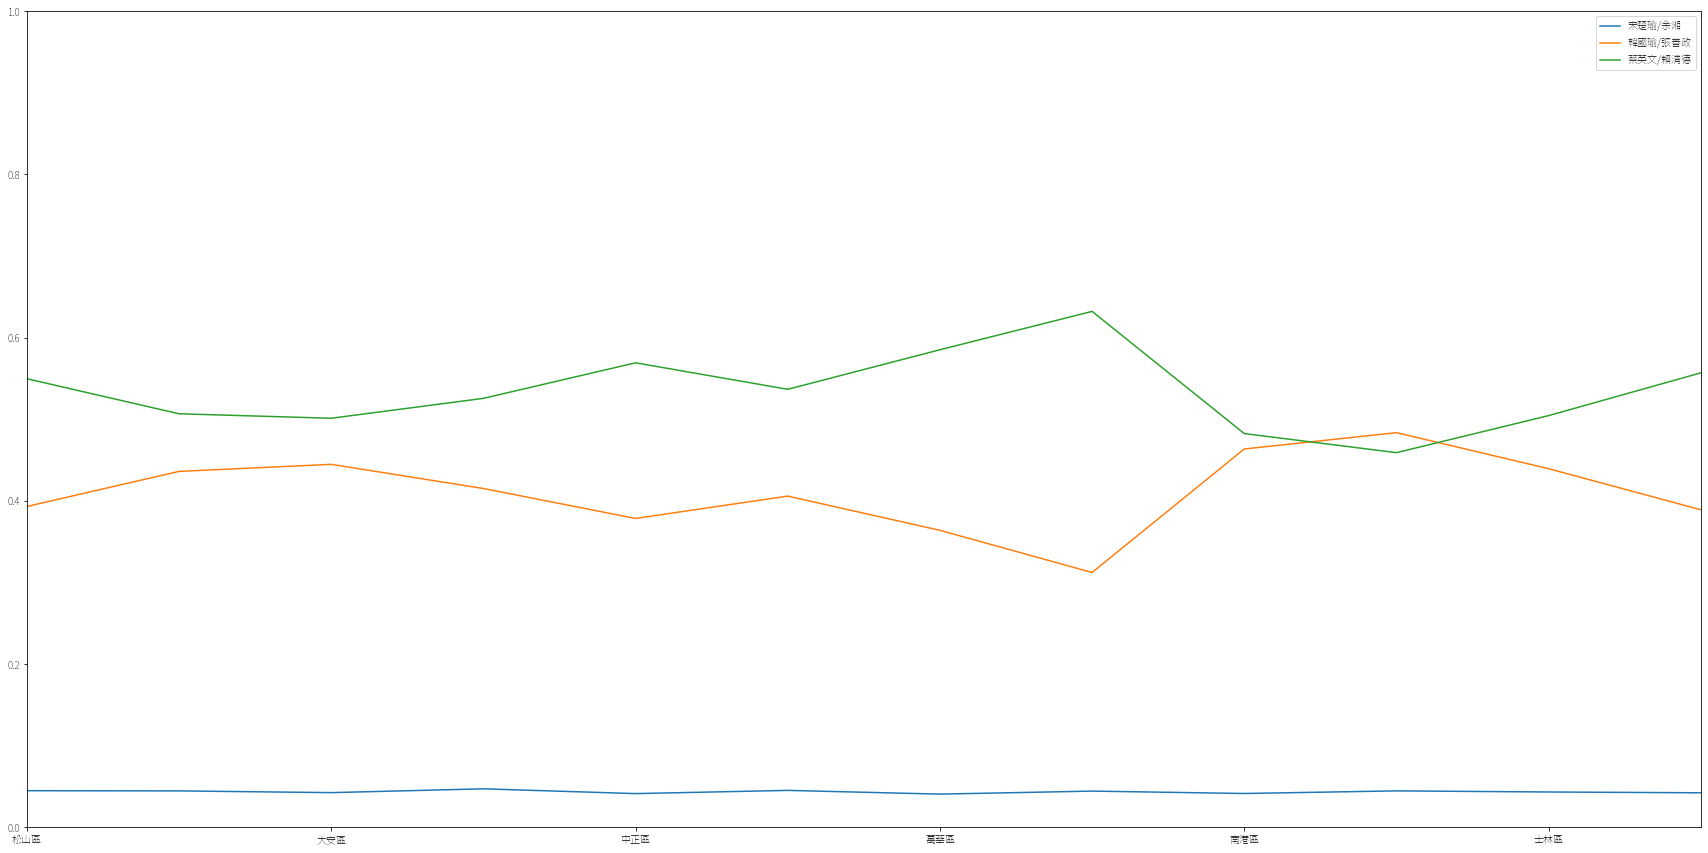

In [336]:
plt.rcParams["figure.figsize"] = (30,15)
Test.plot(kind = 'line',rot = 0)
plt.ylim((0,1))
plt.show()

#### 3-3: 請計算各組候選人在各行政區域的行政里，最高得票的候選人

In [214]:
df

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,"1,100",79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,"1,137",77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,"1,114",76.4811
5,松山區,莊敬里,576.0,43,389,462,894,14,908,0,908,271,"1,179",77.0144
6,松山區,東榮里,577.0,38,431,545,"1,014",18,1032,0,"1,032",272,"1,304",79.1411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,北投區,泉源里,156.0,48,372,721,"1,141",8,1149,0,"1,149",448,"1,597",71.9474
1737,北投區,湖山里,157.0,25,219,344,588,5,593,0,593,212,805,73.6646
1738,北投區,湖山里,158.0,23,191,282,496,7,503,0,503,188,691,72.7931
1739,北投區,大屯里,159.0,34,195,542,771,10,781,0,781,300,"1,081",72.2479


In [311]:
# 蔡英文/賴清德 到得票數最高的開票所
xls_df2[(xls_df2['蔡英文/賴清德'] >= xls_df2['韓國瑜/張善政']) & (xls_df2['蔡英文/賴清德'] >= xls_df2['宋楚瑜/余湘'])].count()

# 韓國瑜/張善政 到得票數最高的開票所
#xls_df2[(xls_df2['韓國瑜/張善政'] >= xls_df2['蔡英文/賴清德']) & (xls_df2['韓國瑜/張善政'] >= xls_df2['宋楚瑜/余湘'])].count()

# 宋楚瑜/余湘 到得票數最高的開票所
#xls_df2[(xls_df2['宋楚瑜/余湘'] >= xls_df2['蔡英文/賴清德']) & (xls_df2['宋楚瑜/余湘'] >= xls_df2['韓國瑜/張善政'])].count()

區域         1380
村里別        1380
投票所別       1380
宋楚瑜/余湘     1380
韓國瑜/張善政    1380
蔡英文/賴清德    1380
有效票數       1380
無效票數       1380
投票數        1380
已領未投票數     1380
發出票數       1380
用餘票數       1380
選舉人數       1380
投票率        1380
dtype: int64

In [307]:
xls_df2.head()

,區域,村里別,投票所別,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德,有效票數,無效票數,投票數,已領未投票數,發出票數,用餘票數,選舉人數,投票率
2,松山區,莊敬里,573.0,36,391,429,856,14,870,0,870,230,1100,79.0909
3,松山區,莊敬里,574.0,46,382,438,866,12,878,0,878,259,1137,77.2208
4,松山區,莊敬里,575.0,48,393,389,830,22,852,0,852,262,1114,76.4811
5,松山區,莊敬里,576.0,43,389,462,894,14,908,0,908,271,1179,77.0144
6,松山區,東榮里,577.0,38,431,545,1014,18,1032,0,1032,272,1304,79.1411


In [308]:
max_district = xls_df2.groupby('村里別')[['宋楚瑜/余湘','韓國瑜/張善政','蔡英文/賴清德']].sum()

In [309]:
# 蔡英文/賴清德 到得票數最高的行政里
can3 = max_district[(max_district['蔡英文/賴清德'] >= max_district['韓國瑜/張善政']) & (max_district['蔡英文/賴清德'] >= max_district['宋楚瑜/余湘'])]

# 韓國瑜/張善政 到得票數最高的行政里
can2 = max_district[(max_district['韓國瑜/張善政'] >= max_district['蔡英文/賴清德']) & (max_district['韓國瑜/張善政'] >= max_district['宋楚瑜/余湘'])]

# 宋楚瑜/余湘 到得票數最高的行政里
can1 = max_district[(max_district['宋楚瑜/余湘'] >= max_district['蔡英文/賴清德']) & (max_district['宋楚瑜/余湘'] >= max_district['韓國瑜/張善政'])]

can1

,宋楚瑜/余湘,韓國瑜/張善政,蔡英文/賴清德
村里別,,,


#### 3-4: 請畫出三組候選人在各行政區得票數的群組長條圖

In [313]:
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC'] # 將字體換成 Noto Sans CJK TC
plt.rcParams['axes.unicode_minus']=False # 修復負號顯示問題
plt.rcParams["figure.figsize"] = (9,6) # 設定預設製圖大小

In [314]:
# 在各里的得票數
pos1 = xls_df2.groupby('區域')['宋楚瑜/余湘'].sum().values
pos2 = xls_df2.groupby('區域')['韓國瑜/張善政'].sum().values
pos3 = xls_df2.groupby('區域')['蔡英文/賴清德'].sum().values

district_name = xls_df2.groupby('區域')['蔡英文/賴清德'].sum().index.values

In [315]:
print(pos1)
print(pos2)
print(pos3)
print(district_name)

[6367 4188 5878 8356 6443 3409 7185 3463 7534 7502 5436 5008]
[56491 41461 62353 74437 59851 30968 65183 24673 85490 82305 55918 46700]
[ 79022  48183  70285  94269  90060  40969 104881  50006  88977  78129
  64207  66866]
['\u3000中山區' '\u3000中正區' '\u3000信義區' '\u3000內湖區' '\u3000北投區' '\u3000南港區'
 '\u3000士林區' '\u3000大同區' '\u3000大安區' '\u3000文山區' '\u3000松山區' '\u3000萬華區']


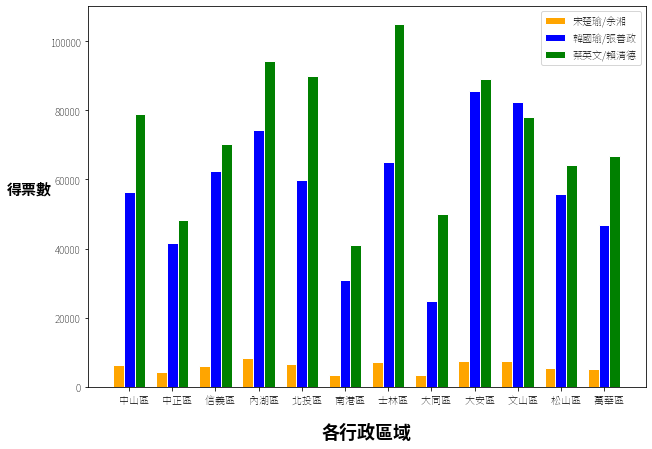

In [316]:
pos1 = list(pos1)
pos2 = list(pos2)
pos3 = list(pos3)

plt.figure(figsize=(10,7)) # 設定此圖大小

barWidth = 0.25 # x 軸每個 bar 名稱的間距

district_name = list(district_name) # 長條圖在 x 軸 的每個 bar 名稱
r1 = np.arange(len(pos1))       # 繪製'宋楚瑜/余湘'每一根長條圖的位置
r2 = [x + barWidth for x in r1] # 繪製'韓國瑜/張善政'每一根長條圖的位置
r3 = [x + barWidth for x in r2] # 繪製'蔡英文/賴清德'每一根長條圖的位置

plt.bar(r1, pos1, color='orange', width=barWidth, edgecolor='white', label='宋楚瑜/余湘')
plt.bar(r2, pos2, color='blue', width=barWidth, edgecolor='white', label='韓國瑜/張善政')
plt.bar(r3, pos3, color='green', width=barWidth, edgecolor='white', label='蔡英文/賴清德')

plt.xticks([r + barWidth for r in range(len(pos1))], district_name)
plt.xlabel('各行政區域', fontweight='bold', fontsize=18, labelpad=18)
plt.ylabel('得票數', fontweight='bold', fontsize=15, rotation=0, labelpad=20) # label: 相隔距離
plt.legend()

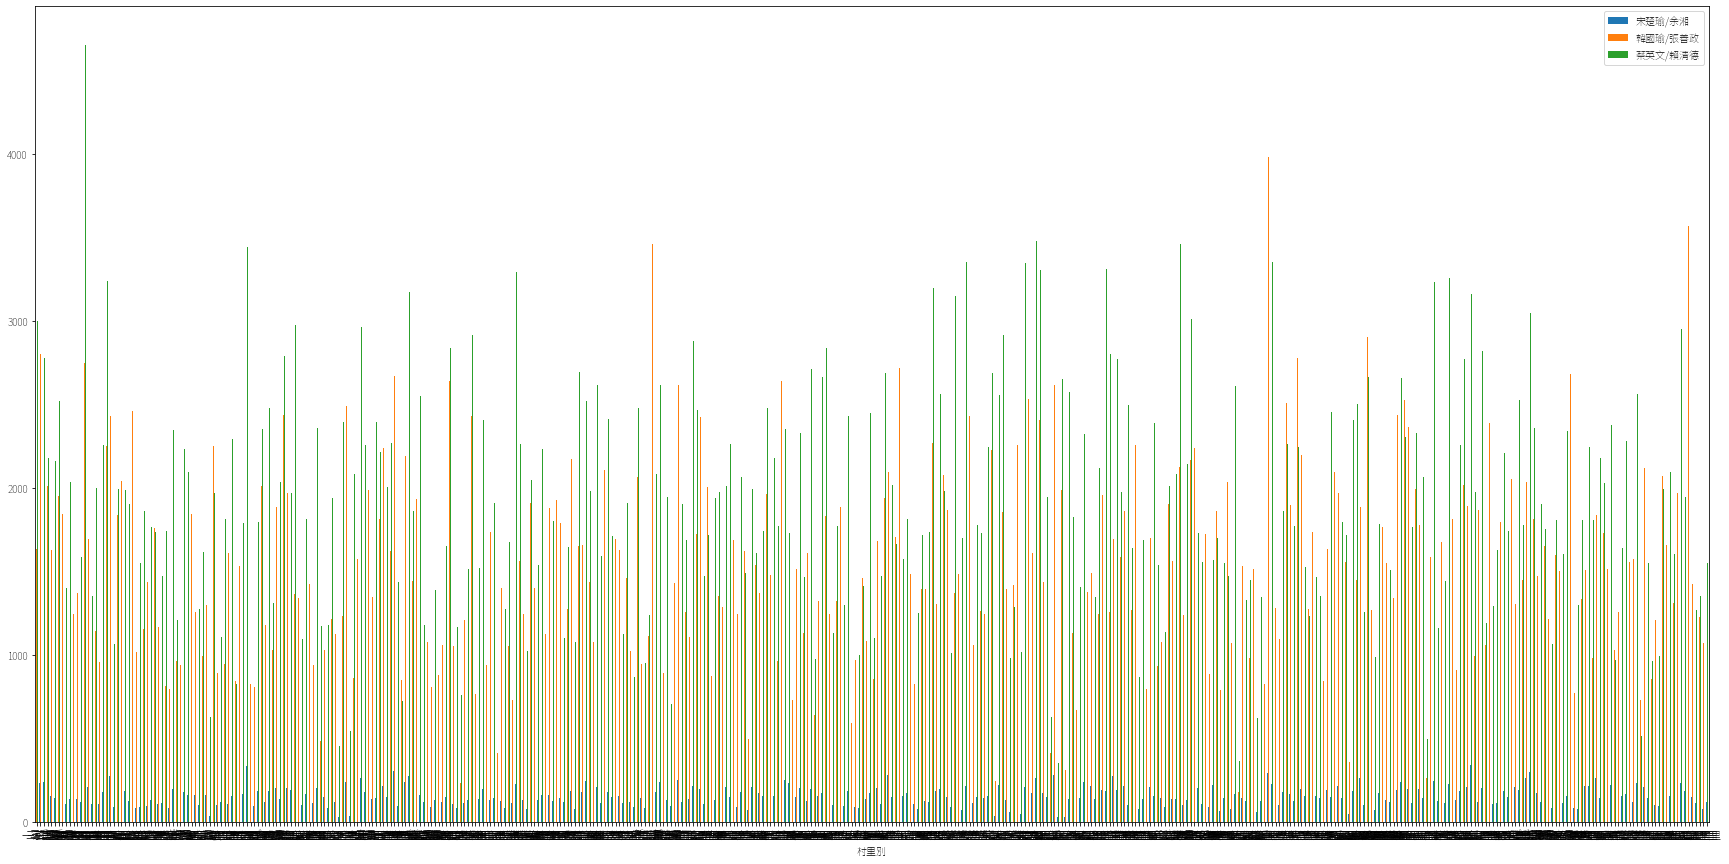

In [298]:
Test=df.groupby(by='村里別')[['宋楚瑜/余湘','韓國瑜/張善政','蔡英文/賴清德']].sum()
Test.plot(kind = 'bar',rot = 0)
plt.show()

#### 3-5 請畫出三組候選人在各行政區得票數的 Stacked Barplot (堆疊群組長條圖)

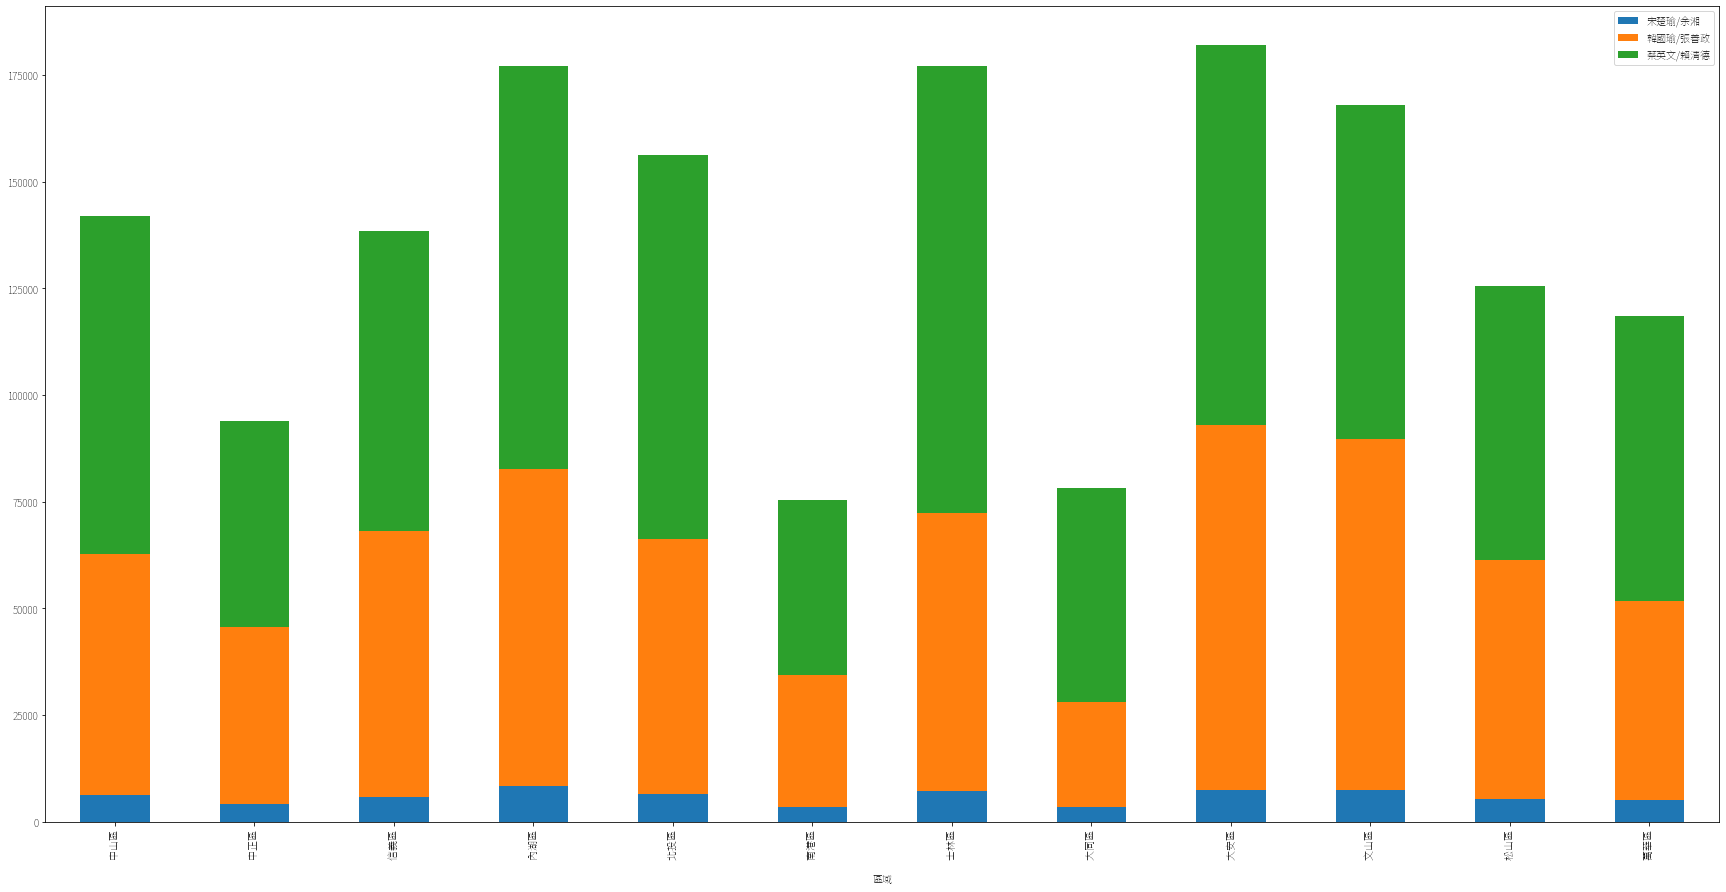

In [295]:
Test.plot(kind='bar', stacked=True)
plt.show()

In [338]:
print(pos1)
print(np.add(pos1, pos2))

[6367, 4188, 5878, 8356, 6443, 3409, 7185, 3463, 7534, 7502, 5436, 5008]
[62858 45649 68231 82793 66294 34377 72368 28136 93024 89807 61354 51708]


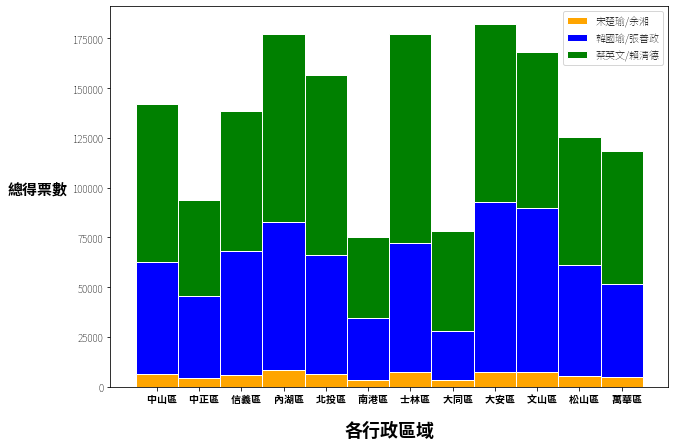

In [339]:
pos1 = list(pos1)
pos2 = list(pos2)
pos3 = list(pos3)

plt.figure(figsize=(10,7)) # 設定此圖大小
 
# pos1 + pos2 的高度
# 因為 pos3 的位置是放在 pos1 + pos2 之上
posS = list(np.add(pos1, pos2))
# OR posS = np.add(pos1, pos2).tolist()

# 長條圖在 x 軸 的每個 bar 名稱
district_name = list(district_name)

# 每個 bar 在 x-axis 的位置
r = list(range(1, 13, 1))

# 長條圖在 x 軸 的每個 bar 名稱和 bar 寬度
district_name = list(district_name) 
barWidth = 1.0 # bar 寬度

#--- 製作 stacked bar ---#
# 第一層 
plt.bar(r, pos1, color='orange', edgecolor='white', width=barWidth, label='宋楚瑜/余湘')
# 第二層 
plt.bar(r, pos2, bottom=pos1, color='blue', edgecolor='white', width=barWidth, label='韓國瑜/張善政')
# 第三層 (此層架在第一層+第二層合起來的高度之上) (posS)
plt.bar(r, pos3, bottom=posS, color='green', edgecolor='white', width=barWidth, label='蔡英文/賴清德')
 
# x 軸設定名稱和字體
plt.xticks(r, district_name, fontweight='bold')
plt.xlabel('各行政區域', fontweight='bold', fontsize=18, labelpad=18)
plt.ylabel('總得票數', fontweight='bold', fontsize=15, rotation=0, labelpad=35) # label: 相隔距離
plt.legend()

Workshop 4-6: 請畫出三組候選人在各行政里得票數的Percent Stacked Barplot (百分比堆疊長條圖)

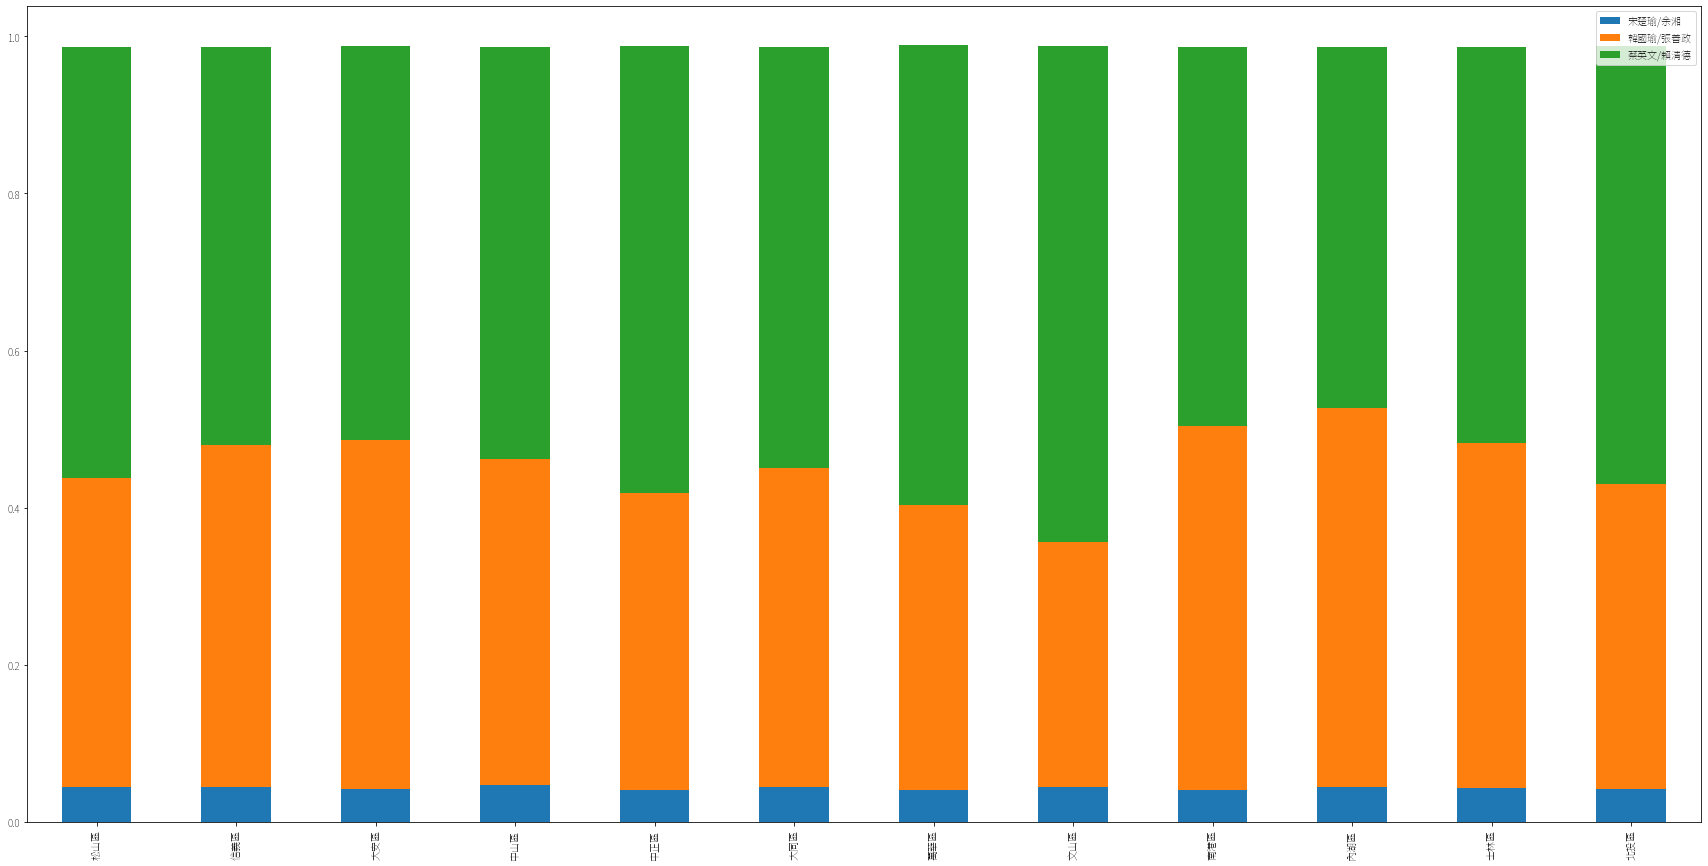

In [337]:
Test.plot(kind='bar', stacked=True)
plt.show()

In [294]:
#Test
x=['x','x','y']
myset = set(x)
myset

{'x', 'y'}